In [26]:
import os
import pandas as pd

BASE_DIR = os.getcwd()
print("Current working directory:", BASE_DIR)

DATA_PATH = os.path.join(BASE_DIR, "data", "raw", "creditcard.csv")
print("Trying to load:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
df.head()


Current working directory: /Users/rajveerarneja/Desktop/cost_sensitive_fraud_detection
Trying to load: /Users/rajveerarneja/Desktop/cost_sensitive_fraud_detection/data/raw/creditcard.csv


,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,1,84.47,22,Electronics,0,0,66,3,40,0
1,2,541.82,3,Travel,1,0,87,1,64,0
2,3,237.01,17,Grocery,0,0,49,1,61,0
3,4,164.33,4,Grocery,0,1,72,3,34,0
4,5,30.53,15,Food,0,0,79,0,44,0


In [28]:
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [31]:
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# Drop categorical column for now
X = X.drop("merchant_category", axis=1)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [34]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [35]:
y_test_probs = log_reg.predict_proba(X_test_scaled)[:, 1]
y_test_probs[:10]


array([3.56827451e-03, 3.64682721e-04, 9.88428215e-07, 4.80911432e-03,
       1.32607636e-04, 4.19040385e-02, 1.94341925e-10, 8.04777845e-03,
       9.47956279e-07, 8.70466433e-04])

In [36]:
threshold = 0.02  # 2%

y_pred_02 = (y_test_probs >= threshold).astype(int)

y_pred_02[:10]


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [37]:
import numpy as np

COST_FP = 500
COST_FN = 10000

def compute_total_cost(y_true, y_pred):
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return fp * COST_FP + fn * COST_FN


In [38]:
total_cost_02 = compute_total_cost(y_test.values, y_pred_02)
total_cost_02


np.int64(142500)

In [39]:
import numpy as np

thresholds = np.linspace(0.001, 0.1, 50)  # 0.1% to 10%
costs = []

for t in thresholds:
    y_pred = (y_test_probs >= t).astype(int)
    cost = compute_total_cost(y_test.values, y_pred)
    costs.append(cost)

best_threshold = thresholds[np.argmin(costs)]
best_threshold


np.float64(0.1)

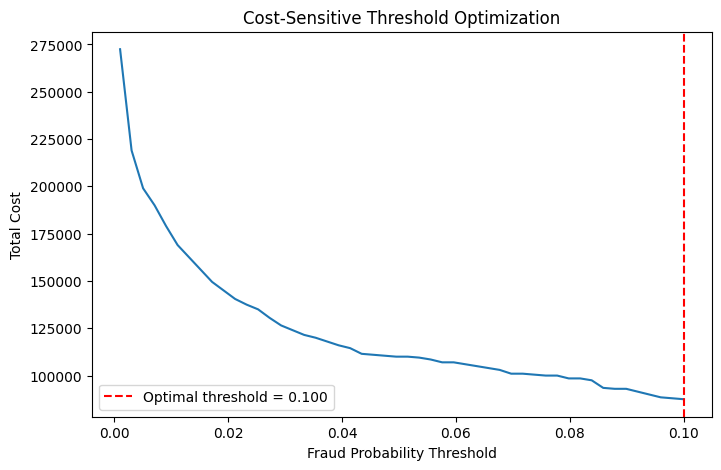

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(thresholds, costs)
plt.axvline(best_threshold, color='red', linestyle='--',
            label=f'Optimal threshold = {best_threshold:.3f}')
plt.xlabel("Fraud Probability Threshold")
plt.ylabel("Total Cost")
plt.title("Cost-Sensitive Threshold Optimization")
plt.legend()
plt.show()


In [41]:
idx = np.argmax(y_test_probs)  # most suspicious transaction
idx, y_test_probs[idx]


(np.int64(1874), np.float64(0.9999987300400587))

In [42]:
important_features = np.abs(log_reg.coef_[0])
feature_importance = sorted(
    zip(X.columns, important_features),
    key=lambda x: x[1],
    reverse=True
)

feature_importance[:5]


[('device_trust_score', np.float64(3.488252207459575)),
 ('transaction_hour', np.float64(3.090884890179237)),
 ('velocity_last_24h', np.float64(2.395940703661263)),
 ('location_mismatch', np.float64(2.0945581955072914)),
 ('foreign_transaction', np.float64(2.0869331425938835))]